# Detector data compression

This python notebook will show you how to obtain and manipulate image data captured with Dectris detectors. Prerequisites can be found in requirements.txt. Using a Conda environment is recommended.

In [ ]:
%pip install zenodo-get h5py hdf5plugin matplotlib dask

## Data download

In [14]:
datasets = {
    'lyso' : '3631118', #x-ray crystallography
    'smb6': '8320619', #transmission electron microscopy
    'thaumatin' : '2529979' #x-ray crystallography
}

In [ ]:
import os


for name, file_url in datasets.items():
    cmd = f'zenodo_get -o ./{name}/ {file_url}'
    os.system(cmd)

## Opening the files

In [37]:
import h5py
import hdf5plugin

import glob

    

def h5_tree(val, pre=''):
    items = len(val)
    for key, val in val.items():
        items -= 1
        if items == 0:
            # the last item
            if type(val) == h5py._hl.group.Group:
                print(pre + '└── ' + key)
                h5_tree(val, pre+'    ')
            else:
                try:
                    print(pre + '└── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '└── ' + key + ' (scalar)')
        else:
            if type(val) == h5py._hl.group.Group:
                print(pre + '├── ' + key)
                h5_tree(val, pre+'│   ')
            else:
                try:
                    print(pre + '├── ' + key + ' (%d)' % len(val))
                except TypeError:
                    print(pre + '├── ' + key + ' (scalar)')


h5_files = {}
h5_file_paths = {}
for name, file_url in datasets.items():
    list = glob.glob(f'./{name}/*master.h5')
    h5_files[name] = h5py.File(list[0])
    h5_file_paths[name] = list[0]
    print(name)
    h5_tree(h5_files[name])

lyso
└── entry
    ├── data
    │   ├── data_000001 (100)
    │   ├── data_000002 (100)
    │   ├── data_000003 (100)
    │   ├── data_000004 (100)
    │   ├── data_000005 (100)
    │   ├── data_000006 (100)
    │   ├── data_000007 (100)
    │   ├── data_000008 (100)
    │   ├── data_000009 (100)
    │   ├── data_000010 (100)
    │   ├── data_000011 (100)
    │   ├── data_000012 (100)
    │   ├── data_000013 (100)
    │   ├── data_000014 (100)
    │   ├── data_000015 (100)
    │   ├── data_000016 (100)
    │   ├── data_000017 (100)
    │   ├── data_000018 (100)
    │   ├── data_000019 (100)
    │   ├── data_000020 (100)
    │   ├── data_000021 (100)
    │   ├── data_000022 (100)
    │   ├── data_000023 (100)
    │   ├── data_000024 (100)
    │   ├── data_000025 (100)
    │   ├── data_000026 (100)
    │   ├── data_000027 (100)
    │   ├── data_000028 (100)
    │   ├── data_000029 (100)
    │   ├── data_000030 (100)
    │   ├── data_000031 (100)
    │   ├── data_000032 (100)
    │   ├── 

## Plotting

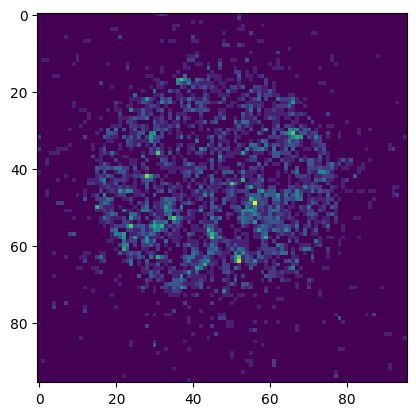

In [30]:
import matplotlib.pyplot as plt
smb6_images = h5_files['smb6']['entry/data']['data_000001'][0:100]

plt.imshow(smb6_images[1])

## Writing modified data to disk

It is recommended to use `dask` for writing the compressed data to disk. This can be set up to run in parallel on chunks and most importantly without loading the entire dataset into memory.

The code snippet below exemplifies this by copying the first of the `entry/data` keys to a copy of the dataset. The lambda function below can be replaced by an compression algorithm working on 3-dimensional numpy arrays.

In [50]:
import dask.array as da
from dask.diagnostics import ProgressBar
import numpy as np

name = 'smb6'
key = 'data_000001'
os.system(f'mkdir {name}_compressed')
os.system(f'cp {name}/* {name}_compressed/')
dest_file_path = h5_file_paths[name].replace(name, f'{name}_compressed')

dset = da.from_array(h5_files[name]['entry/data'][key])
compressed_dset = dset.map_blocks(lambda x : x, meta=np.array((), dtype=np.uint16))

with ProgressBar():
    da.to_hdf5(dest_file_path, {'entry/data/' + key: compressed_dset})


mkdir: cannot create directory ‘smb6_compressed’: File exists


[########################################] | 100% Completed | 3.63 ss
